# Assignment 1 - Jan Zimmermann
Folgendes Jupiter Notebook kombiniert die Daten unterschiedlichen Datenquellen, um die beste Gemeinde des Kantons Schaffhausen zu bestimmen. Dabei werden drei unterschiedliche Kategorien untersucht:
1. Alterstatistik: Welche Gemeinde hat Prozentual die meisten Personen, welche Wein konsumieren dürfen und zudem sich weiterbilden können.
2. Weinstatistik: 
3. Bildungslast Statistik: 

In [237]:
import numpy as np
import pandas as pd
import requests
from io import StringIO
from bs4 import BeautifulSoup
import tabula
import matplotlib.pyplot as plt

### Altersstatistik pro Gemeinde
Die Alterstatistik bildet die übergeordnete Datensammlung. Diese Datenbasis gilt als `source of truth`, sofern es Abweichungen gibt der Gemeindenamen bei anderen Statistiken gibt, behält diese Statistik stets die Oberhand.

*Quellen*: 
- http://de.wikipedia.org/wiki/Gemeinden_des_Kantons_Schaffhausen
Laden der Gemeindenamen als `source of truth`
- https://image.shkb.ch/dynamic/noop/387c5e5dc5b11b214cd0f1397cb34ceba3aa91eb/kanton-schaffhausen-in-zahlen-1.pdf, Seite 12 - 13, Jahr 23/24: Laden der Anzahl Personen pro Altersgruppe und das Total der Einwohner pro Gemeinde.

In [238]:
url = 'http://de.wikipedia.org/wiki/Gemeinden_des_Kantons_Schaffhausen'
# Lade den HTML-Code der Wikipedia-Seite
response = requests.get(url)
html_content = response.content

# Verwende BeautifulSoup, um die Tabelle zu extrahieren
soup = BeautifulSoup(html_content, 'html.parser')
table = soup.find('table')  # Hier musst du die richtige Tabelle identifizieren, falls es mehrere gibt

# Verwende Pandas, um die Tabelle in ein DataFrame zu konvertieren
html_string = str(table)
df_parts = pd.read_html(StringIO(html_string))[0]  # Wrap the HTML string with StringIO
df_parts = df_parts.iloc[:, [1,3,5]]
df_parts = df_parts.drop(len(df_parts)-1).reset_index(drop=True)
df_parts.columns = ['Gemeinde', 'Fläche (km²)', 'Bezirk']
df_parts['Gemeinde'] = df_parts['Gemeinde'].str.replace(" (SH)", '')

In [239]:
# Pfadeingabe zum PDF
pdf_path = "data/kanton-schaffhausen-in-zahlen.pdf"

# Lese das PDF in ein Pandas DataFrame ein

df_bev_raw = tabula.read_pdf(pdf_path, pages='all', multiple_tables=True)[7]
df_bev_raw = df_bev_raw.drop(0).reset_index(drop=True)
df_bev_raw.columns = ['Gemeinde', 'Total Einwohner', 'Schweizerinnen und Schweizer', 'Ausländerinnen und Ausländer', '0 – 19 Jahre', '20 – 64 Jahre', '65 – 79 Jahre', 'über 80 Jahre']
# Liste der Spalten, die bearbeitet werden sollen
columns_to_process = ['Total Einwohner', 'Schweizerinnen und Schweizer', 'Ausländerinnen und Ausländer', '0 – 19 Jahre', '20 – 64 Jahre', '65 – 79 Jahre', 'über 80 Jahre']
# Iteriere über die ausgewählten Spalten und führe die Operationen durch
for column in columns_to_process:
    try:
        df_bev_raw[column] = pd.to_numeric(df_bev_raw[column].str.replace('\'', ''), errors='raise')
    except ValueError as e:
        print(f"Error converting column '{column}': {e}")
        
df_bev_raw = df_bev_raw.fillna(0)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tabula/io.py:1045: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors="ignore")
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tabula/io.py:1045: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors="ignore")


In [240]:
# Zusammenführen der Gemeindenamen Daten und der Altersstatistik von Schauffhausen
df_main = pd.merge(df_parts, df_bev_raw, on='Gemeinde', how='inner')
df_main['Fläche pro Einwohner (km²)'] = df_main['Fläche (km²)'] / df_main['Total Einwohner']
df_main = df_main.iloc[:, [0,10,3,6,7,8,9]]

In [242]:
# Berechne die prozentuale Verteilung pro Gemeinde und Altersgruppe zu der Gesamt Einwohnerzahl pro Gemeinde
df_main_calc = df_main.copy().iloc[:, [0]]
df_main_calc['0 – 19 Jahre'] = df_main['0 – 19 Jahre'] / df_main['Total Einwohner'] * 100
df_main_calc['20 – 64 Jahre'] = df_main['20 – 64 Jahre'] / df_main['Total Einwohner'] * 100
df_main_calc['65 – 79 Jahre'] = df_main['65 – 79 Jahre'] / df_main['Total Einwohner'] * 100
df_main_calc['über 80 Jahre'] = df_main['über 80 Jahre'] / df_main['Total Einwohner'] * 100

for col in df_main_calc.columns[1:5]:
    min_value = df_main_calc[col].min()
    max_value = df_main_calc[col].max()
    df_main_calc[f'Normalized {col}'] = ((df_main_calc[col] - min_value) / (max_value - min_value)) * 100

# Berechne die Anzahl Punkte pro Gemeinde mit der Gewichtung 0-19 Jahre = 30%, 20-64 Jahre = 60%, 65-79 Jahre = 10%, über 80 Jahre = 0%
df_main_calc['Punkte Altersverteilung'] = df_main_calc['Normalized 0 – 19 Jahre'] * 0.3 + df_main_calc['Normalized 20 – 64 Jahre'] * 0.6 + df_main_calc['Normalized 65 – 79 Jahre'] * 0.1 + df_main_calc['Normalized über 80 Jahre'] * 0.0
df_main_final = df_main_calc.copy().iloc[:, [0,9]]
df_main_final = df_main_final.sort_values(by='Punkte Altersverteilung', ascending=False)

# Ausgabe der TOP 5 Gemeinden der Altersstatistik
df_main_final.head()

,Gemeinde,Punkte Altersverteilung
0,Bargen,65.466238
22,Stetten,55.857288
16,Ramsen,54.795694
9,Hemishofen,50.355522
2,Beringen,50.020022


### Weinstatistiken pro Gemeinde
Die Weinstatistik zeigt auf, welche Gemeinden die grösste Anbaufläche der Rebsorten Blauburgunder (Pinot noir), Chardonnay und Sauvignon blanc aufweisen. Es wird dann die Annahme getätigt, dass die Gemeinde mit den grössten Anbauflächen der Weine auch gleichzeitige diese sind mit dem grössten Konsum dieser Weine.

*Quellen*:
- https://sh.ch/CMS/get/file/bb067876-9c87-4df5-afa0-26bb3ba428b1, Seite 11, Jahr 2022: Laden der Rebsorten Anbauflächen pro Gemeinde

In [243]:
# Pfadeingabe zum PDF
pdf_path = "data/Rebbericht_2022_SH_TG_def_2.pdf"

# Lese das PDF in ein Pandas DataFrame ein
df_wein_raw = tabula.read_pdf(pdf_path, pages='all', multiple_tables=True)[2]

# Erzeuge ein DataFrame mit den benötigten Spalten
df_wein = df_wein_raw.iloc[:, [0,1,3,9]]
df_wein.columns = ['Gemeinde', 'Blauburgunder Fläche', 'Chardonnay Fläche', 'Sauvignon blanc Fläche']

# Lösche die erste, letzte und leere Zeilen
df_wein = df_wein.drop(0).reset_index(drop=True)
df_wein = df_wein.drop(len(df_wein)-1).reset_index(drop=True)
df_wein = df_wein.dropna(subset=['Gemeinde']).reset_index(drop=True)

df_wein['Gemeinde'] = df_wein['Gemeinde'].str.replace(" (SH)", '')

# Liste der Spalten, die bearbeitet werden sollen
columns_to_process = ['Blauburgunder Fläche', 'Chardonnay Fläche', 'Sauvignon blanc Fläche']
# Iteriere über die ausgewählten Spalten und führe die Operationen durch
for column in columns_to_process:
    try:
        df_wein[column] = pd.to_numeric(df_wein[column].str.replace('\'', ''), errors='raise')
    except ValueError as e:
        print(f"Error converting column '{column}': {e}")
        
df_wein = df_wein.fillna(0) # Setze 0.0 bei allen undefinierten Werten.

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/tabula/io.py:1045: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[c] = pd.to_numeric(df[c], errors="ignore")


In [244]:
df_wein_calc = df_wein.copy().iloc[:, [0]]

for col in df_wein.columns[1:4]:
    min_value = df_wein[col].min()
    max_value = df_wein[col].max()
    df_wein_calc[f'Normalized {col}'] = ((df_wein[col] - min_value) / (max_value - min_value)) * 100

# Berechne die Anzahl Punkte pro Gemeinde mit der Gewichtung Blauburgunder = 50%, Chardonnay Jahre = 10% und Sauvignon blanc = 40%
df_wein_calc['Punkte Wein'] = df_wein_calc['Normalized Blauburgunder Fläche'] * 0.5 + df_wein_calc['Normalized Chardonnay Fläche'] * 0.1 + df_wein_calc['Normalized Sauvignon blanc Fläche'] * 0.4

# Zusammenführen der Gemeindenamen Daten und der Weinstatistik von Schauffhausen
df_wein_final = pd.merge(df_wein_calc, df_main, on='Gemeinde', how='right').iloc[:, [0,4]]
df_wein_final = df_wein_final.fillna(0)
df_wein_final = df_wein_final.sort_values(by='Punkte Wein', ascending=False)

# Ausgabe der TOP 5 Gemeinden der Weinstatistik
df_wein_final.head()

,Gemeinde,Punkte Wein
8,Hallau,100.000000
25,Wilchingen,43.410649
15,Oberhallau,30.822208
24,Trasadingen,17.899844
21,Stein am Rhein,16.139949


### Bildungslast Statistik pro Gemeinde

Die Bildungslast zeigt auf, welche Gemeinden die höchste Bildungslast in Franken pro Einwohner aufweist. Dabei werden die Jahre 2016, 2014 und 2012 verglichen. Je höher die Bildungslast ist, desto besser unter der Annahme, dass die Einwohner der Gemeinde mit der höchsten Last auch die am meisten gebildeten sind. 

*Quellen*:
- https://sh.ch/CMS/get/file/988d765c-07c2-4983-9eca-cdee5c06fa57, Jahr 2017: Laden der Bildungslast in Franken / Einwohner pro Gemeinde. 

In [250]:
excel_path = "data/Bildungslast 7.12.xls"

sheet_name = "7.12"
start_row = 8
end_row = 42

# Lese den definierten Bereich in das DataFrame
df_bildung_raw = pd.read_excel(excel_path, sheet_name=sheet_name, skiprows=range(1, start_row))

# Lade ausschliesslich die benötigten Spalten
df_bildung_raw = df_bildung_raw.iloc[0:end_row-start_row]
df_bildung = df_bildung_raw.iloc[:, [0,10,12,14]]
df_bildung.columns = ['Gemeinde', '2012 pro Einwohner (CHF)', '2014 pro Einwohner (CHF)', '2016 pro Einwohner (CHF)']

# Entferne Zeilen, welche keine Einträge aufweisen im Jahr 2016
df_bildung = df_bildung.dropna(subset=['2016 pro Einwohner (CHF)']).reset_index(drop=True)
df_bildung = df_bildung.sort_values(by='2016 pro Einwohner (CHF)', ascending=False)

In [253]:
df_bildung_calc = df_bildung.copy().iloc[:, [0]]

for col in df_bildung.columns[1:4]:
    min_value = df_bildung[col].min()
    max_value = df_bildung[col].max()
    df_bildung_calc[f'Normalized {col}'] = ((df_bildung[col] - min_value) / (max_value - min_value)) * 100

# Berechne die Anzahl Punkte pro Gemeinde mit der Gewichtung 2012 = 10%, 2014 = 30% und 2016 = 60%
df_bildung_calc['Punkte Bildung'] = (df_bildung_calc['Normalized 2012 pro Einwohner (CHF)'] * 0.1 + df_bildung_calc['Normalized 2014 pro Einwohner (CHF)'] * 0.3 + df_bildung_calc['Normalized 2016 pro Einwohner (CHF)'] * 0.6)

# Zusammenführen der Gemeindenamen Daten und der Weinstatistik von Schauffhausen
df_bildung_final = pd.merge(df_bildung_calc, df_main, on='Gemeinde', how='right').iloc[:, [0,1,2,3,4]]
df_bildung_final = df_bildung_final.fillna(0)
df_bildung_final = df_bildung_final.sort_values(by='Punkte Bildung', ascending=False)

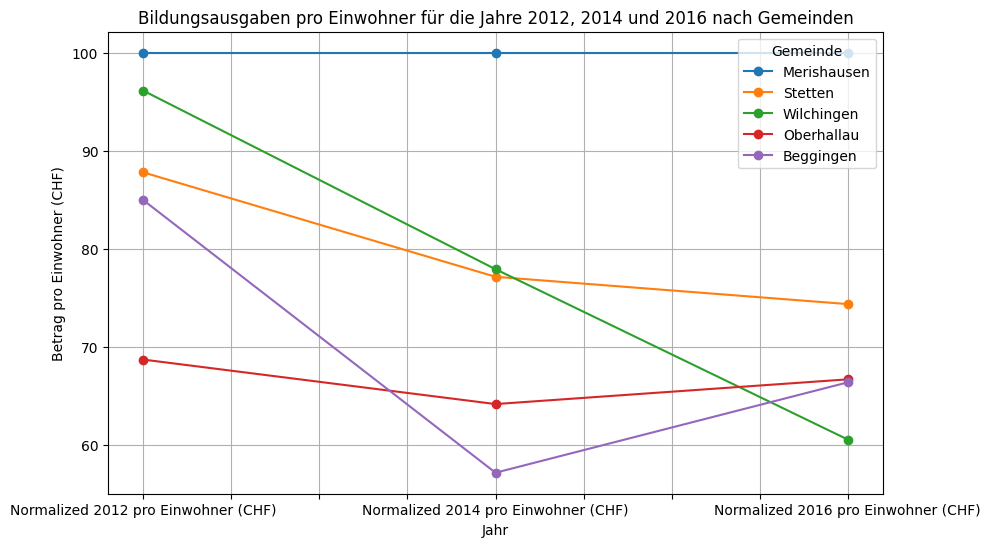

In [254]:
# Visualizierung der TOP 5 Gemeinden der Weinstatistik
df_bildung_graph = df_bildung_final.copy().iloc[:, [0,1,2,3]]

# Setze die Gemeinde als Index und transponiere das DataFrame, um die Gemeinden als Linie darzustellen
df_bildung_graph.set_index('Gemeinde', inplace=True)
df_bildung_graph = df_bildung_graph.head().T

# Plot des Liniendiagramms
plt.rcParams['figure.figsize'] = [10, 6]
df_bildung_graph.plot(marker='o')
plt.ylabel('Betrag pro Einwohner (CHF)')
plt.xlabel('Jahr')
plt.title('Bildungsausgaben pro Einwohner für die Jahre 2012, 2014 und 2016 nach Gemeinden')
plt.legend(title='Gemeinde')
plt.grid(True)
plt.show()

Die obige Grafik visualisiert den Bildungslast Verlauf der Top 5 Gemeinden in dieser Statistik. Daraus kann man ableiten, dass `Merishausen` stets die grösste finanzielle Unterstützung in der Bildung pro Einwohner geniessen konnte. Wobei sich die Bildungslast in `Wilchingen` von Jahr zu Jahr zu verschlechtern scheint. 

### Gesamt Gewinner
Gemeinde mit der besten Einwohnerverteilung, welche Wein trinken dürfen, der grössten Rebanbaufläche und zudem die teuerste Bildung geniesst pro Einwohner ist der Gewinner.

In [ ]:
# Zusammenführen der drei finalen DataFrames
df_final = pd.merge(pd.merge(df_main_final, df_wein_final, on='Gemeinde', how='inner'), df_bildung_final, on='Gemeinde', how='inner')

# Berechnung der Gesamtpunktzahl 
df_final['Punkte Gesamt'] = (df_final['Punkte Altersverteilung'] + df_final['Punkte Wein'] + df_final['Punkte Bildung']) / 3

df_final = df_final.sort_values(by='Punkte Gesamt', ascending=False)

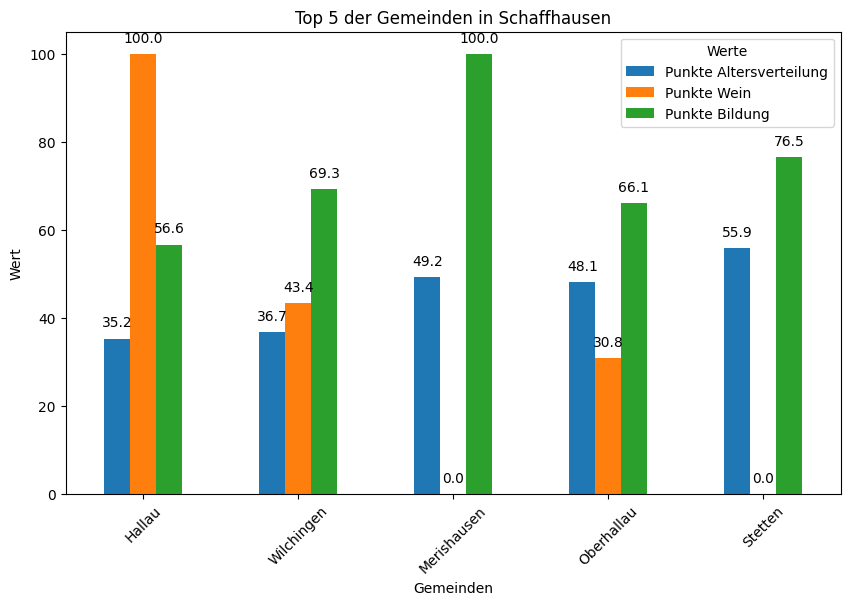

In [ ]:
# Plot des Balkendiagramms
plt.rcParams['figure.figsize'] = [10, 6]
ax = df_final.head().iloc[:, :-1].plot(kind='bar',x='Gemeinde')
ax.set_ylabel('Wert')
ax.set_xlabel('Gemeinden')
ax.set_title('Top 5 der Gemeinden in Schaffhausen')
plt.xticks(rotation=45)
plt.legend(title='Werte')

# Zeige die Werte für jede Säule
for i in ax.patches:
    ax.text(i.get_x() + i.get_width() / 2, i.get_height() + 2, str(round(i.get_height(), 1)), ha='center', va='bottom')

plt.show()

Die obige Grafik zeigt die einzelnen Kategorien der Top 5 Gemeinden

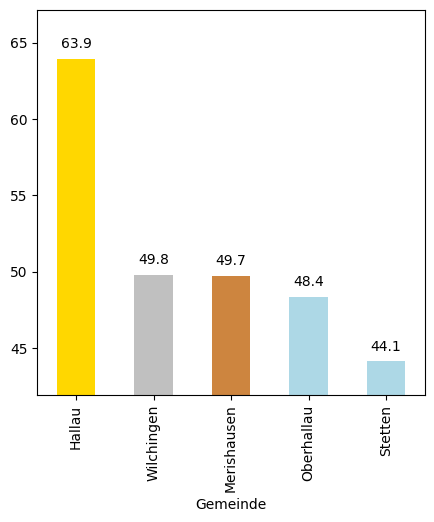

In [ ]:
df_final_graph_min_value = df_final.head()['Punkte Gesamt'].min() * 0.95
plt.rcParams['figure.figsize'] = [5, 5]
colors = ['gold', 'silver', 'peru', 'lightblue', 'lightblue']
df_final_graph = df_final.head().plot.bar(x='Gemeinde', y='Punkte Gesamt', color=colors, legend=False)
df_final_graph.set_ylim(df_final_graph_min_value, None)
for i, v in enumerate(df_final.head()['Punkte Gesamt']):
    df_final_graph.text(i, v + 0.5, str(round(v, 1)), ha='center', va='bottom')
plt.show()
